In [1]:
%pylab inline
import xarray as xr
import pandas as pd

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [ ]:
region = 'nh'

variable = 'TMAX'
file_path_hot = f'../processed_data/preprocessed_{region}_TMAX_data.nc'
# file_path_hot = f'../processed_data/ushcn_replaced_{variable}_data.nc'

variable = 'TMIN'
file_path_cold = f'../processed_data/preprocessed_{region}_TMAX_data.nc'
# file_path_cold = f'../processed_data/ushcn_replaced_{variable}_data.nc'

In [3]:
print(f"Loading preprocessed {variable} data for {region.upper()} region from {file_path_hot}...")

ds = xr.open_dataset(file_path_hot)

print(ds)

Loading preprocessed TMIN data for US region from ../processed_data/preprocessed_us_TMAX_data.nc...


<xarray.Dataset> Size: 924MB
Dimensions:      (time: 45534, latitude: 13, longitude: 30)
Coordinates:
  * longitude    (longitude) float32 120B -124.5 -122.5 -120.5 ... -68.5 -66.5
  * latitude     (latitude) float32 52B 24.5 26.5 28.5 30.5 ... 44.5 46.5 48.5
  * time         (time) datetime64[ns] 364kB 1900-01-01 ... 2024-08-31
Data variables:
    date_number  (time, latitude, longitude) float64 142MB ...
    year         (time, latitude, longitude) float64 142MB ...
    month        (time, latitude, longitude) float64 142MB ...
    day          (time, latitude, longitude) float64 142MB ...
    day_of_year  (time, latitude, longitude) float64 142MB ...
    land_mask    (time, latitude, longitude) float64 142MB ...
    temperature  (time, latitude, longitude) float32 71MB ...
Attributes: (12/13)
    Conventions:             Berkeley Earth Internal Convention (based on CF-...
    title:                   Preprocessed US Temperature Data for EPA Figure ...
    history:                 05

In [4]:
# Create a new data structure for May 1 to Sept 30 records
print("Creating data structure for warm season records...")

# First, create a mask for the warm season dates (May 1 to Sept 30)
dates = pd.to_datetime(ds.time.values)
warm_season_mask = (dates.month >= 5) & (dates.month <= 9)

# Get the day of year for each date and create a mapping to 0-152 (153 days total)
# May 1 = day 121, Sept 30 = day 273
days_in_warm_season = dates[warm_season_mask].dayofyear
unique_days = np.sort(np.unique(days_in_warm_season))
print(f"\nWarm season spans {len(unique_days)} days from May 1 to Oct. 31")

# Create a new dataset to store the years of maximum temperature
warm_season_records = xr.Dataset(
    {
        'year_of_max_temp': (('latitude', 'longitude', 'day'), 
                            np.full((len(ds.latitude), len(ds.longitude), len(unique_days)), np.nan)),
        'max_temp': (('latitude', 'longitude', 'day'), 
                    np.full((len(ds.latitude), len(ds.longitude), len(unique_days)), np.nan))
    },
    coords={
        'latitude': ds.latitude,
        'longitude': ds.longitude,
        'day': unique_days  # Using day of year as coordinate
    }
)

print("\nProcessing each grid point...")
# For each grid point
for lat_idx in range(len(ds.latitude)):
    if lat_idx % 3 == 0:  # Progress indicator
        print(f"Processing latitude {lat_idx+1}/{len(ds.latitude)}")
        
    for lon_idx in range(len(ds.longitude)):
        # Get temperature series for this location
        temp_series = ds.temperature.isel(latitude=lat_idx, longitude=lon_idx)
        year_series = ds.year.isel(latitude=lat_idx, longitude=lon_idx)
        
        # Skip if no valid data
        if temp_series.isnull().all():
            continue
            
        # For each day in the warm season
        for day_idx, day in enumerate(unique_days):
            # Get all temperatures for this day of year
            day_mask = (dates.dayofyear == day) & warm_season_mask
            day_temps = temp_series[day_mask]
            day_years = year_series[day_mask]
            
            # Skip if no valid data for this day
            if day_temps.isnull().all():
                continue
                
            # Find the maximum temperature and its year
            max_temp = float(day_temps.max(skipna=True))
            max_idx = day_temps.argmax(skipna=True)
            max_year = float(day_years[max_idx])
            
            # Store the results
            warm_season_records.year_of_max_temp[lat_idx, lon_idx, day_idx] = max_year
            warm_season_records.max_temp[lat_idx, lon_idx, day_idx] = max_temp

print("\nData structure created!")
print(warm_season_records)

# Save warm_season_records to a global variable to ensure it's available in the next cell
# globals()['warm_season_records'] = warm_season_records


Creating data structure for warm season records...

Warm season spans 154 days from May 1 to Oct. 31

Processing each grid point...
Processing latitude 1/13


Processing latitude 4/13


Processing latitude 7/13


Processing latitude 10/13


Processing latitude 13/13



Data structure created!
<xarray.Dataset> Size: 962kB
Dimensions:           (latitude: 13, longitude: 30, day: 154)
Coordinates:
  * latitude          (latitude) float32 52B 24.5 26.5 28.5 ... 44.5 46.5 48.5
  * longitude         (longitude) float32 120B -124.5 -122.5 ... -68.5 -66.5
  * day               (day) int32 616B 121 122 123 124 125 ... 271 272 273 274
Data variables:
    year_of_max_temp  (latitude, longitude, day) float64 480kB nan ... 2.02e+03
    max_temp          (latitude, longitude, day) float64 480kB nan nan ... 22.99


In [5]:
# Load TMIN data
print("Loading TMIN data...")
ds_min = xr.open_dataset(file_path_cold)

# Create a mask for the cold season dates (Dec 1 to March 31)
dates_min = pd.to_datetime(ds_min.time.values)
cold_season_mask = ((dates_min.month >= 12) | (dates_min.month <= 3))

# Get the day of year for each date in cold season
days_in_cold_season = dates_min[cold_season_mask].dayofyear
unique_cold_days = np.sort(np.unique(days_in_cold_season))
print(f"\nCold season spans {len(unique_cold_days)} days from Nov 1 to Apr 30")

# Create a new dataset to store the years of minimum temperature
cold_season_records = xr.Dataset(
    {
        'year_of_min_temp': (('latitude', 'longitude', 'day'), 
                            np.full((len(ds_min.latitude), len(ds_min.longitude), len(unique_cold_days)), np.nan)),
        'min_temp': (('latitude', 'longitude', 'day'), 
                    np.full((len(ds_min.latitude), len(ds_min.longitude), len(unique_cold_days)), np.nan))
    },
    coords={
        'latitude': ds_min.latitude,
        'longitude': ds_min.longitude,
        'day': unique_cold_days
    }
)

print("\nProcessing each grid point for cold season records...")
# For each grid point
for lat_idx in range(len(ds_min.latitude)):
    if lat_idx % 3 == 0:  # Progress indicator
        print(f"Processing latitude {lat_idx+1}/{len(ds_min.latitude)}")
        
    for lon_idx in range(len(ds_min.longitude)):
        # Get temperature series for this location
        temp_series = ds_min.temperature.isel(latitude=lat_idx, longitude=lon_idx)
        year_series = ds_min.year.isel(latitude=lat_idx, longitude=lon_idx)
        
        # Skip if no valid data
        if temp_series.isnull().all():
            continue
            
        # For each day in the cold season
        for day_idx, day in enumerate(unique_cold_days):
            # Get all temperatures for this day of year
            day_mask = (dates_min.dayofyear == day) & cold_season_mask
            day_temps = temp_series[day_mask]
            day_years = year_series[day_mask]
            
            # Skip if no valid data for this day
            if day_temps.isnull().all():
                continue
                
            # Find the minimum temperature and its year
            min_temp = float(day_temps.min(skipna=True))
            min_idx = day_temps.argmin(skipna=True)
            min_year = float(day_years[min_idx])
            
            # Store the results
            cold_season_records.year_of_min_temp[lat_idx, lon_idx, day_idx] = min_year
            cold_season_records.min_temp[lat_idx, lon_idx, day_idx] = min_temp

print("\nData structure created!")
print(cold_season_records)

# Save to global variable
# globals()['cold_season_records'] = cold_season_records


Loading TMIN data...

Cold season spans 123 days from Nov 1 to Apr 30

Processing each grid point for cold season records...
Processing latitude 1/13


Processing latitude 4/13


Processing latitude 7/13


Processing latitude 10/13


Processing latitude 13/13



Data structure created!
<xarray.Dataset> Size: 768kB
Dimensions:           (latitude: 13, longitude: 30, day: 123)
Coordinates:
  * latitude          (latitude) float32 52B 24.5 26.5 28.5 ... 44.5 46.5 48.5
  * longitude         (longitude) float32 120B -124.5 -122.5 ... -68.5 -66.5
  * day               (day) int32 492B 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
Data variables:
    year_of_min_temp  (latitude, longitude, day) float64 384kB nan ... 1.996e+03
    min_temp          (latitude, longitude, day) float64 384kB nan ... -16.81


Creating combined analysis of temperature records...
Valid stations: Warm season=281, Cold season=281


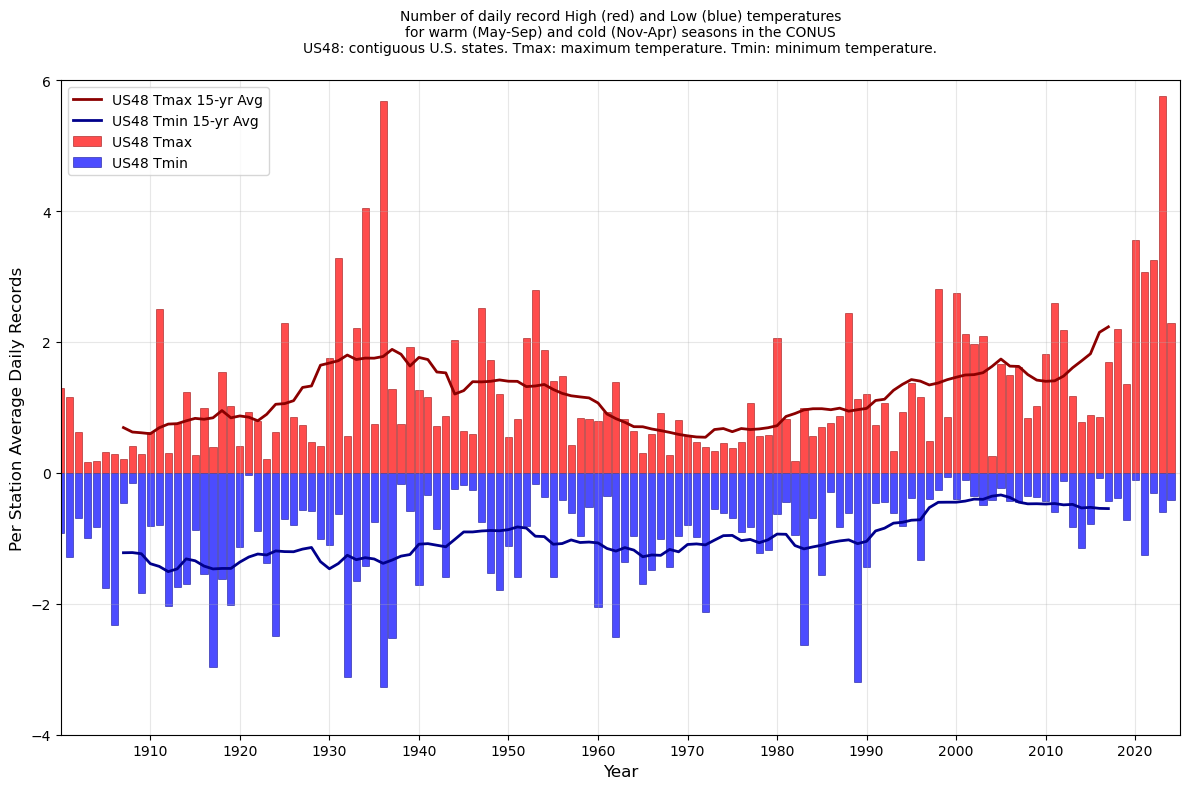


Record Statistics:
Total grid points: 390
Valid grid points: 281

Warm Season (May-Sep) High Temperature Records:
Total records: 43274
Average records per station: 154.0

Cold Season (Nov-Apr) Low Temperature Records:
Total records: 34563
Average records per station: 123.0

Top 5 years for high temperature records:
2023: 5.75 records per station
1936: 5.68 records per station
1934: 4.05 records per station
2020: 3.56 records per station
1931: 3.29 records per station

Top 5 years for low temperature records:
1936: 3.27 records per station
1989: 3.19 records per station
1932: 3.12 records per station
1917: 2.97 records per station
1983: 2.63 records per station


In [6]:
# Create DOE-style figure combining warm season highs and cold season lows
print("Creating combined analysis of temperature records...")

try:
    # Setup year range
    years = np.arange(1900, 2025)
    high_counts = np.zeros(len(years))
    low_counts = np.zeros(len(years))

    # Process warm season high temperature records
    all_high_years = warm_season_records.year_of_max_temp.values.flatten()
    all_high_years = all_high_years[~np.isnan(all_high_years)]

    # Process cold season low temperature records
    all_low_years = cold_season_records.year_of_min_temp.values.flatten()
    all_low_years = all_low_years[~np.isnan(all_low_years)]

    # Count records per year
    for i, year in enumerate(years):
        high_counts[i] = np.sum(all_high_years == year)
        low_counts[i] = np.sum(all_low_years == year)

    # Calculate records per station
    n_stations = len(ds.latitude) * len(ds.longitude)
    # Count stations with at least one valid record in either season
    valid_stations_warm = np.sum(~np.isnan(warm_season_records.year_of_max_temp).any(dim='day')).values
    valid_stations_cold = np.sum(~np.isnan(cold_season_records.year_of_min_temp).any(dim='day')).values
    valid_stations = max(valid_stations_warm, valid_stations_cold)  # Use the larger number
    
    print(f"Valid stations: Warm season={valid_stations_warm}, Cold season={valid_stations_cold}")
    
    # Calculate per-station averages
    avg_highs = high_counts / valid_stations
    avg_lows = low_counts / valid_stations

    # Calculate 15-year running averages (centered)
    window_size = 15
    smooth_highs = pd.Series(avg_highs).rolling(window=window_size, center=True).mean()
    smooth_lows = pd.Series(avg_lows).rolling(window=window_size, center=True).mean()

    # Create the plot
    plt.figure(figsize=(12, 8))

    # Set labels based on region
    if region == 'us':
        tmax_label = 'US48 Tmax'
        tmin_label = 'US48 Tmin'
        tmax_avg_label = 'US48 Tmax 15-yr Avg'
        tmin_avg_label = 'US48 Tmin 15-yr Avg'
        region_description = 'contiguous U.S. states'
    else:  # region == 'nh'
        tmax_label = 'NH Tmax'
        tmin_label = 'NH Tmin'
        tmax_avg_label = 'NH Tmax 15-yr Avg'
        tmin_avg_label = 'NH Tmin 15-yr Avg'
        region_description = 'northern hemisphere mid-latitude'

    # Plot annual data as bars
    plt.bar(years, avg_highs, width=0.8, color='red', alpha=0.7, 
            label=tmax_label, edgecolor='darkred', linewidth=0.5)
    plt.bar(years, -avg_lows, width=0.8, color='blue', alpha=0.7, 
            label=tmin_label, edgecolor='darkblue', linewidth=0.5)

    # Plot 15-year running averages as lines
    plt.plot(years, smooth_highs, color='darkred', linewidth=2, 
            label=tmax_avg_label)
    plt.plot(years, -smooth_lows, color='darkblue', linewidth=2, 
            label=tmin_avg_label)

    # Formatting
    plt.xlim(1900, 2025)
    
    # Calculate y-limits based on data
    max_high = max(max(avg_highs), max(smooth_highs.dropna()))
    max_low = max(max(avg_lows), max(smooth_lows.dropna()))
    y_max = min(8, np.ceil(max_high))
    y_min = max(-6, -np.ceil(max_low))
    plt.ylim(y_min, y_max)
    
    plt.grid(True, alpha=0.3)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Per Station Average Daily Records', fontsize=12)
    plt.legend(loc='upper left', fontsize=10)

    # Set axis ticks
    plt.yticks(range(int(y_min), int(y_max) + 1, 2))
    plt.xticks(range(1910, 2025, 10))

    # Add title based on region
    if region == 'us':
        title_text = ('Number of daily record High (red) and Low (blue) temperatures\n' +
                     'for warm (May-Sep) and cold (Nov-Apr) seasons in the CONUS\n' +
                     'US48: contiguous U.S. states. Tmax: maximum temperature. Tmin: minimum temperature.')
    else:  # region == 'nh'
        title_text = ('Number of daily record High (red) and Low (blue) temperatures\n' +
                     'for warm (May-Sep) and cold (Nov-Apr) seasons in the northern hemisphere mid-latitude\n' +
                     'NH: northern hemisphere mid-latitude. Tmax: maximum temperature. Tmin: minimum temperature.')
    
    plt.title(title_text, fontsize=10, pad=20)

    plt.tight_layout()
    plt.savefig(f'Figure6.3.3_{region}.png',dpi=300)
    plt.show()

    # Print statistics
    print("\nRecord Statistics:")
    print(f"Total grid points: {n_stations}")
    print(f"Valid grid points: {valid_stations}")
    print(f"\nWarm Season (May-Sep) High Temperature Records:")
    print(f"Total records: {len(all_high_years)}")
    print(f"Average records per station: {len(all_high_years)/valid_stations:.1f}")
    print(f"\nCold Season (Nov-Apr) Low Temperature Records:")
    print(f"Total records: {len(all_low_years)}")
    print(f"Average records per station: {len(all_low_years)/valid_stations:.1f}")

    # Print top 5 years for each
    print("\nTop 5 years for high temperature records:")
    high_top_idx = np.argsort(avg_highs)[-5:][::-1]
    for idx in high_top_idx:
        print(f"{years[idx]}: {avg_highs[idx]:.2f} records per station")

    print("\nTop 5 years for low temperature records:")
    low_top_idx = np.argsort(avg_lows)[-5:][::-1]
    for idx in low_top_idx:
        print(f"{years[idx]}: {avg_lows[idx]:.2f} records per station")

except Exception as e:
    print(f"Error: {str(e)}")
    print("Please make sure to run the previous cells first to create the required datasets.")

## other code

In [7]:
# Check average number of NaNs in temperature data for each year
# This tells you whether the missing data is changing over time
print("Analyzing NaN values in temperature data by year...")

years = ds.year.values
temp_data = ds.temperature.values

for year in np.unique(years[~np.isnan(years)]):
    # Get mask for this year
    year_mask = years == year
    
    # Get temperature data for this year
    year_temp = temp_data[year_mask]
    
    # Count NaNs for this year
    nan_count = np.isnan(year_temp).sum()
    total_values = year_temp.size
    
    # Calculate average NaNs (as percentage)
    avg_nan_percent = (nan_count / total_values) * 100
    
    print(f"Year {int(year)}: {nan_count:,} NaNs out of {total_values:,} values ({avg_nan_percent:.2f}%)")

print("\nOverall statistics:")
total_nans = np.isnan(temp_data).sum()
total_values = temp_data.size
overall_nan_percent = (total_nans / total_values) * 100
print(f"Total NaNs: {total_nans:,} out of {total_values:,} values ({overall_nan_percent:.2f}%)")


Analyzing NaN values in temperature data by year...


Year 1900: 1,825 NaNs out of 104,390 values (1.75%)
Year 1901: 1,825 NaNs out of 104,390 values (1.75%)
Year 1902: 1,825 NaNs out of 104,390 values (1.75%)
Year 1903: 1,825 NaNs out of 104,390 values (1.75%)
Year 1904: 1,830 NaNs out of 104,676 values (1.75%)
Year 1905: 1,825 NaNs out of 104,390 values (1.75%)
Year 1906: 1,825 NaNs out of 104,390 values (1.75%)
Year 1907: 1,825 NaNs out of 104,390 values (1.75%)
Year 1908: 1,830 NaNs out of 104,676 values (1.75%)
Year 1909: 1,825 NaNs out of 104,390 values (1.75%)
Year 1910: 1,825 NaNs out of 104,390 values (1.75%)
Year 1911: 1,825 NaNs out of 104,390 values (1.75%)
Year 1912: 1,830 NaNs out of 104,676 values (1.75%)
Year 1913: 1,825 NaNs out of 104,390 values (1.75%)
Year 1914: 1,825 NaNs out of 104,390 values (1.75%)
Year 1915: 1,825 NaNs out of 104,390 values (1.75%)
Year 1916: 1,830 NaNs out of 104,676 values (1.75%)
Year 1917: 1,825 NaNs out of 104,390 values (1.75%)
Year 1918: 1,825 NaNs out of 104,390 values (1.75%)
Year 1919: 1

Year 1941: 1,825 NaNs out of 104,390 values (1.75%)
Year 1942: 1,825 NaNs out of 104,390 values (1.75%)
Year 1943: 1,825 NaNs out of 104,390 values (1.75%)
Year 1944: 1,830 NaNs out of 104,676 values (1.75%)
Year 1945: 1,825 NaNs out of 104,390 values (1.75%)
Year 1946: 1,825 NaNs out of 104,390 values (1.75%)
Year 1947: 1,825 NaNs out of 104,390 values (1.75%)
Year 1948: 1,830 NaNs out of 104,676 values (1.75%)
Year 1949: 1,825 NaNs out of 104,390 values (1.75%)
Year 1950: 1,825 NaNs out of 104,390 values (1.75%)
Year 1951: 1,825 NaNs out of 104,390 values (1.75%)
Year 1952: 1,830 NaNs out of 104,676 values (1.75%)
Year 1953: 1,825 NaNs out of 104,390 values (1.75%)
Year 1954: 1,825 NaNs out of 104,390 values (1.75%)
Year 1955: 1,825 NaNs out of 104,390 values (1.75%)
Year 1956: 1,830 NaNs out of 104,676 values (1.75%)
Year 1957: 1,825 NaNs out of 104,390 values (1.75%)
Year 1958: 1,825 NaNs out of 104,390 values (1.75%)
Year 1959: 1,825 NaNs out of 104,390 values (1.75%)
Year 1960: 1

Year 1980: 1,830 NaNs out of 104,676 values (1.75%)
Year 1981: 1,825 NaNs out of 104,390 values (1.75%)
Year 1982: 1,825 NaNs out of 104,390 values (1.75%)
Year 1983: 1,825 NaNs out of 104,390 values (1.75%)
Year 1984: 1,830 NaNs out of 104,676 values (1.75%)
Year 1985: 1,825 NaNs out of 104,390 values (1.75%)
Year 1986: 1,825 NaNs out of 104,390 values (1.75%)
Year 1987: 1,825 NaNs out of 104,390 values (1.75%)
Year 1988: 1,830 NaNs out of 104,676 values (1.75%)
Year 1989: 1,825 NaNs out of 104,390 values (1.75%)
Year 1990: 1,825 NaNs out of 104,390 values (1.75%)
Year 1991: 1,825 NaNs out of 104,390 values (1.75%)
Year 1992: 1,830 NaNs out of 104,676 values (1.75%)
Year 1993: 1,825 NaNs out of 104,390 values (1.75%)
Year 1994: 1,825 NaNs out of 104,390 values (1.75%)
Year 1995: 1,825 NaNs out of 104,390 values (1.75%)
Year 1996: 1,830 NaNs out of 104,676 values (1.75%)
Year 1997: 1,825 NaNs out of 104,390 values (1.75%)
Year 1998: 1,825 NaNs out of 104,390 values (1.75%)
Year 1999: 1

Year 2020: 1,830 NaNs out of 104,676 values (1.75%)
Year 2021: 1,825 NaNs out of 104,390 values (1.75%)
Year 2022: 1,825 NaNs out of 104,390 values (1.75%)
Year 2023: 1,825 NaNs out of 104,390 values (1.75%)
Year 2024: 1,220 NaNs out of 69,784 values (1.75%)

Overall statistics:
Total NaNs: 4,963,206 out of 17,758,260 values (27.95%)
